Hello everyone,

In this module, it is required to implement the preprocessor for Arabic Font Identification System.

At first, what are the main steps that we should go through in this module?


# TODOs:

1. Understand the problem
2. Binarization
3. Extract Edges
4. Extract Skeleton
5. Extract Diacritics
6. Extract Text only
7. Testing

classes: ['diwani', 'naskh', 'parsi', 'rekaa', 'thuluth', 'maghribi', 'kufi', 'mohakek', 'Squar-kufic']
labeled images count:  1685
training set count:  1128
testing set count:  557


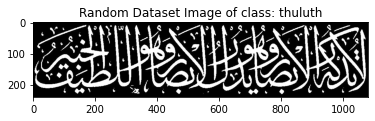

'jupyter' is not recognized as an internal or external command,
operable program or batch file.


In [387]:
##################################################### imports #####################################################
from skimage import io, filters
from skimage.morphology import skeletonize
import cv2
import os
import matplotlib.pyplot as plt
from random import randrange
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.segmentation import flood_fill
%run ../io_utils/io_utils.ipynb

In [388]:
# Read data
dataset_images, dataset_labels = read_data(dataset_path='../ACdata_base')

# 1. Understand the problem

We are interested only in the morphology of text letters, all images are first converted into binary (i.e., black text on a white background). It should be known that most images contain either meaningful texture, which is a part of the decoration or a meaningless one that resulted from the noise while capturing. In either case, we illuminate the background so it does not affect the results.

- Input: --
- Output: --

In [457]:
def analyze_histogram(binary, show_hist=False):

    """Gets a binary image and returns it reverted if text was black (Makes text white for all images)
        Except for Square Kuffi

    Args:
        binary : The binary image you want to transform for consistency (White text on black bg) (Read using cv2)
        
    Returns:
        binary || reverted_binary : The outcome of analysis (Binary image with white text on black bg)
    """

    height = (binary.shape)[0]
    white_pixels_in_row = []
    
    # Calculate number of white pixels in a row
    for row in range(height - 1):
        white_pixels_in_row.append((binary[row, :] == 1).sum())

    # Set the threshold of white pixels in a row to be 70% of the row with most white pixels
    # We use this threshold to see how many rows contain a high number of white pixels 
    pixels_threshold = int(0.7 * max(white_pixels_in_row))

    # Get the number of rows above the pixels_threshold
    rows_above_thresh = 0
    for row_pixels in white_pixels_in_row:
        if row_pixels > pixels_threshold:
            rows_above_thresh += 1

    # Calculate the ratio between the number of rows dominated by white pixels to the number of rows in the entire image
    ratio = rows_above_thresh / height

    # if show_hist:
    #     x = np.arange(height)
    #     plt.figure(figsize =(10, 7)) 
    #     plt.plot(x, white_pixels_in_row)
    #     plt.show()
    
    # If more than 70% of the image is white rows then the background is white and we have to revert the image
    if ratio > 0.7:
        return 1 - binary
    return binary

# 2. Binarization

In [458]:
def binarize(image):
    """Gets an image and returns it binarized having values 0 OR 1 using OTSU thresholding technique

    Args:
        image : The image you want to binarize (Read using cv2)
        
    Returns:
        binarized: The binarized version of the image
    """
    # Use Otsu for normal binarization
    # The parameters are 1-`The input image`, 2-`The binarization threshold (will not be used if OTSU technique is used)`,
    #                        3-`Maximum value`, 4-`Binarization technique`
    th, binary_image = cv2.threshold(image, 128, 1, cv2.THRESH_OTSU)

    # Perform histogram analysis to make text white for all images (Except for square Kuffi)
    corrected_binary_image = analyze_histogram(binary_image)
    return corrected_binary_image

# 3. Extract Edges

In [459]:
def extract_edges(image):
    """Gets the original input image and returns an image containing its edges using canny edge detector

    Args:
        image: The image you want to extract its edges (Read using cv2)
        
    Returns:
        edge_image: The edge extracted image
    """
    # Blur the image for better edge detection
    img_blur = cv2.GaussianBlur(image,(3,3), sigmaX=0, sigmaY=0)

    # Use Canny edge detection to extract edges
    edge_image = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)

    # Change image max value from 255 to 1
    edge_image[edge_image == 255] = 1

    return edge_image

# 4. Extract Skeleton

In [460]:
def extract_skeleton(image):
    """Gets an image and returns an image containing its skeleton 

    Args:
        image: The image you want to skeletonize (Read using cv2)
        
    Returns:
        skeleton: The skeletonized image
    """
    # We start by binarizing the image
    binary = binarize(image)

    # Use Skimage's skeletonize method with the array representation of the binary image as input
    skeleton = skeletonize(np.asarray(binary))

    return skeleton


# 5. Separate Diacritics from Text

In [466]:
def separate_diacritics_and_text(image):
    """Gets an input image of the arabic text and returns an image containing only the diacritics in it and another
        image with the text as a tuple (diacritics, text)
        
    Args:
        image: The image you want to separate its diacritics from its text (Read using cv2)
        
    Returns:
        diacritics_image: A binary image containing only diacritics (white text on black bg)
        text_image: A binary image containing only text (white text on black bg)
    """
    
    binary = binarize(image)    
    height = (binary.shape)[0]
    white_pixels_in_row = np.zeros(height, dtype=np.uint32)
    
    # Calculate number of white pixels in a row
    for row in range(height - 1):
        white_pixels_in_row[row] = (binary[row, :] == 1).sum()

    # Get the row with most white pixels (This row would contain only text and commas no diacritics
    #                                        as it is an imaginary line where text is placed on)
    baseline_row = np.argmax(white_pixels_in_row)
    diacritics_image = binary

    # How Flood Fill works for our case:
    #   It starts at a seed point (pixel) and changes all connected pixels to it to have a certain color
    #   So what we want to do is get the first pixel of each word along the line (it would be black) and  
    #   use that point as seed for the flood_fill algorithm changing that word to have the same color as
    #   the background. We keep doing that for all words until only diacritics remain.

    # Loop through the base_line's pixels to apply flood fill on all words
    rowPixels = binary[baseline_row, :]
    for i in range(len(rowPixels) - 1):
        # Handle the case where the first pixel is part of a word so we apply the flood fill from the end of the word
        if rowPixels[i] == 1 and rowPixels[i+1] == 0:
            diacritics_image = flood_fill(diacritics_image, (baseline_row, i), 0)
        elif rowPixels[i] == 0 and rowPixels[i+1] == 1:
            diacritics_image = flood_fill(diacritics_image, (baseline_row, i+1), 0)

    text_image = binary - diacritics_image
    
    return diacritics_image, text_image

# 6. Testing

In [529]:
def testing():
    
    assert len(dataset_images) == len(dataset_labels)

    directories_names = {1: 'diwani', 2: 'naskh', 3: 'parsi', 4: 'rekaa', 5: 'thuluth', 6: 'maghribi', 7: 'kufi', 8: 'mohakek', 9: 'Squar-kufic',}

    dirname = "../ACdata_base/"

    # Loop through all directories and pick a random test case inside each one
    # Getting a random int doesn't always work because the ranges I assume aren't accurate that's why I use a try except to ignore these cases

    for i in range(1, 10):
        
        try:
            if i == 5:
                filename = format(np.random.randint((i - 1) * 190 + 1, i * 190), '03d') + ".jpg"
            else:
                filename = format(np.random.randint((i - 1) * 190 + 1, i * 190), '04d') + ".jpg"

            test_image = cv2.imread(os.path.join(dirname + str(i), filename), 0)

            binary_image = binarize(test_image)
            assert len(np.unique(np.asarray(binary_image))) == 2


            edge_image = extract_edges(test_image)
            skeleton_image = extract_skeleton(test_image)
            diacritics_image, text_image = separate_diacritics_and_text(test_image)

            f, axarr = plt.subplots(3,2, figsize=(15, 10))
            f.suptitle(directories_names[i] + " test")

            axarr[0,0].imshow(test_image, cmap='gray')
            axarr[0,0].set_title("Original")

            axarr[0,1].imshow(binary_image, cmap='gray')
            axarr[0,1].set_title("Binary")

            axarr[1,0].imshow(edge_image, cmap='gray')
            axarr[1,0].set_title("Edge")

            axarr[1,1].imshow(skeleton_image, cmap='gray')
            axarr[1,1].set_title("Skeleton")

            axarr[2,0].imshow(diacritics_image, cmap='gray')
            axarr[2,0].set_title("Diacritics")

            axarr[2,1].imshow(text_image, cmap='gray')
            axarr[2,1].set_title("Text Only")
        except:
            continue
    


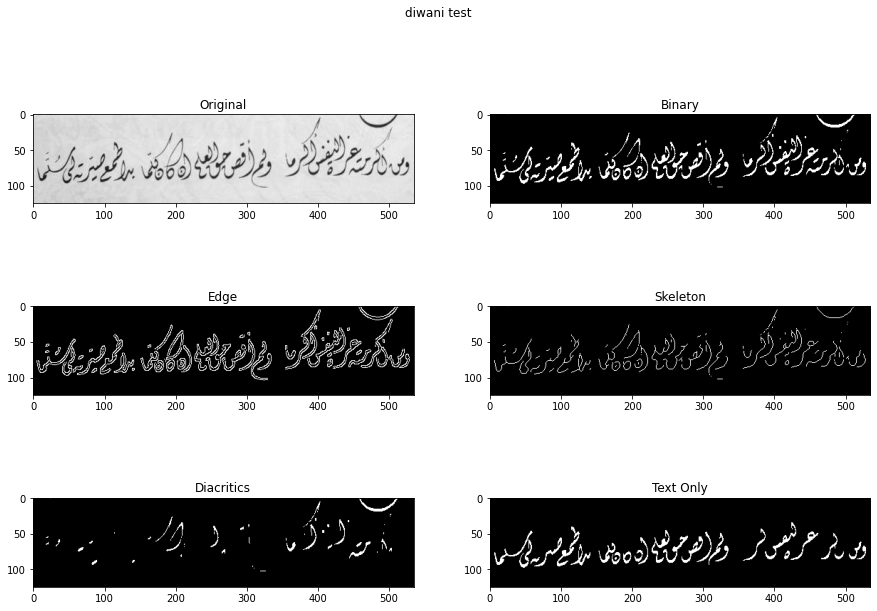

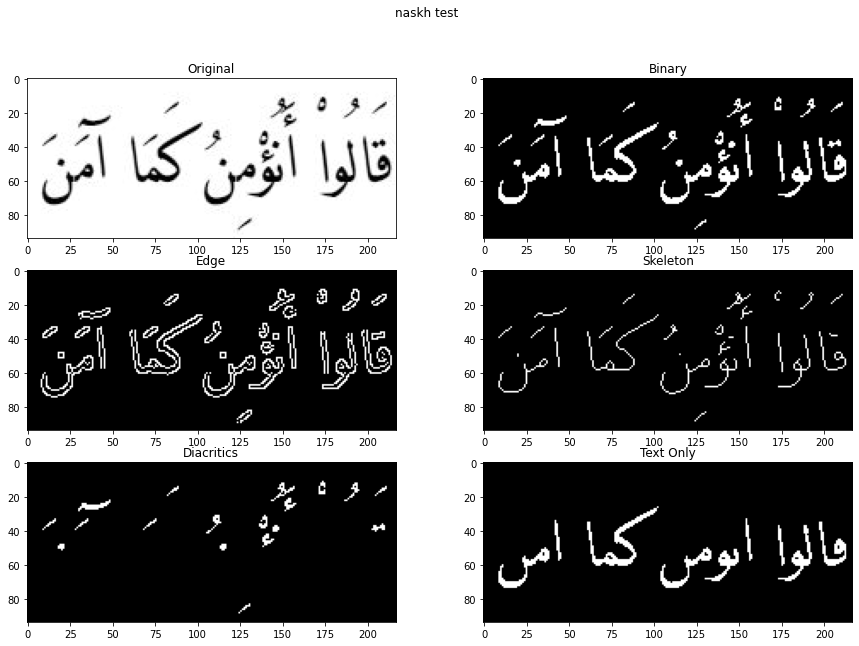

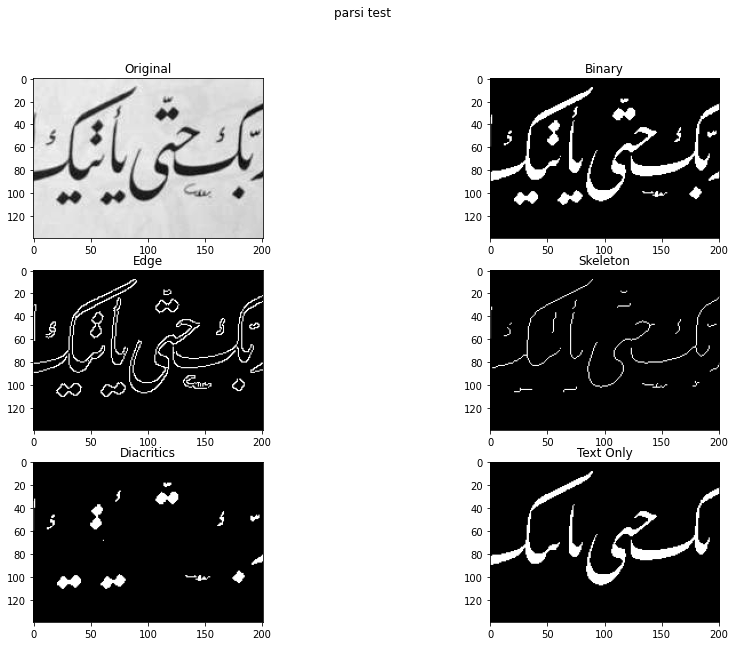

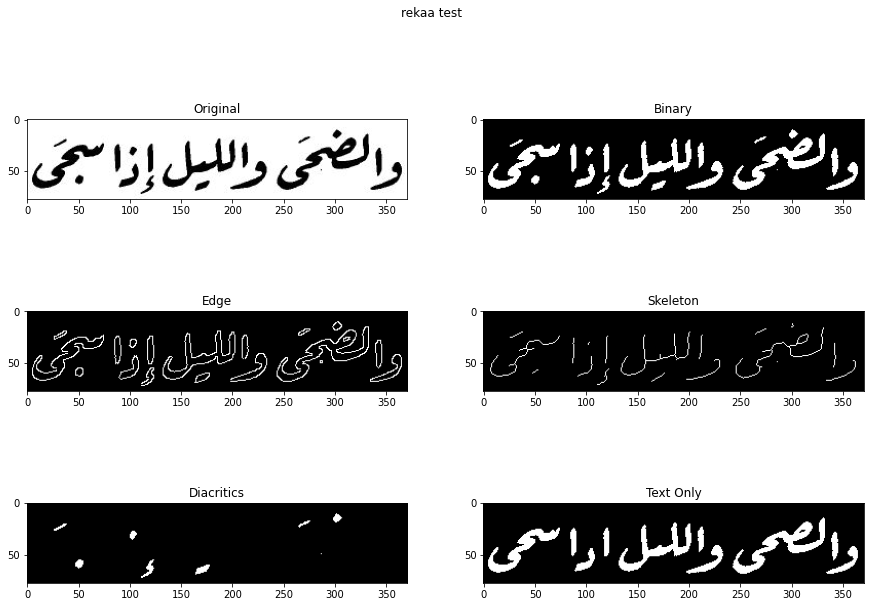

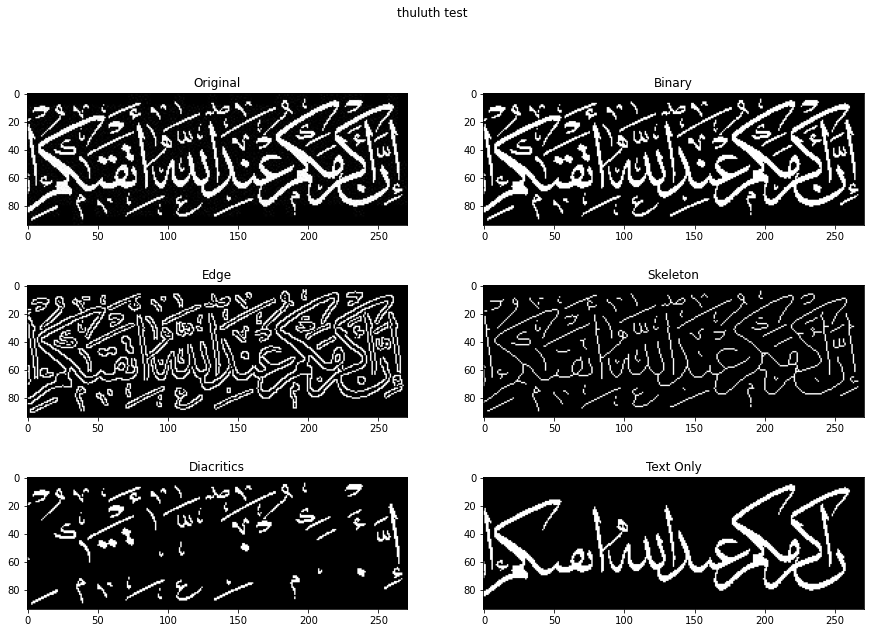

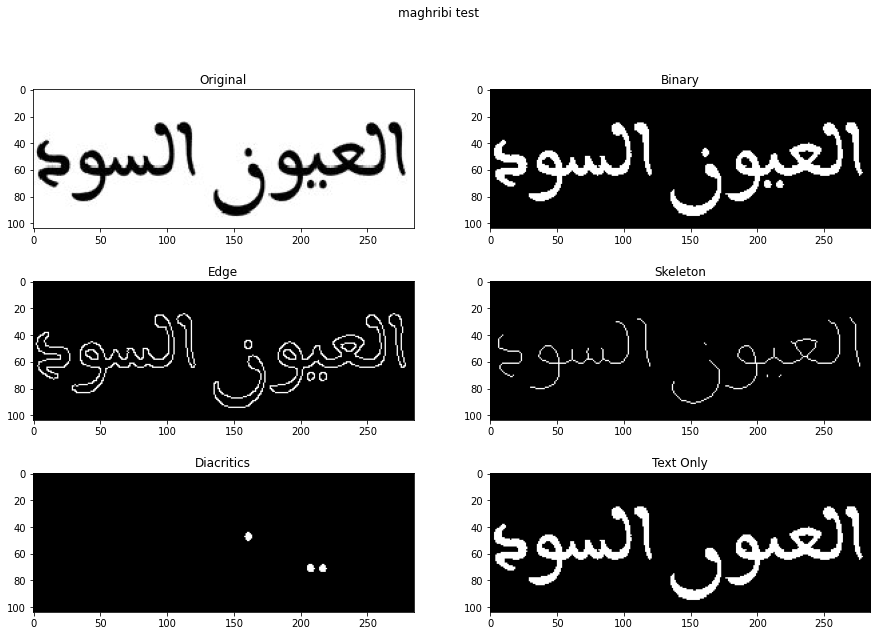

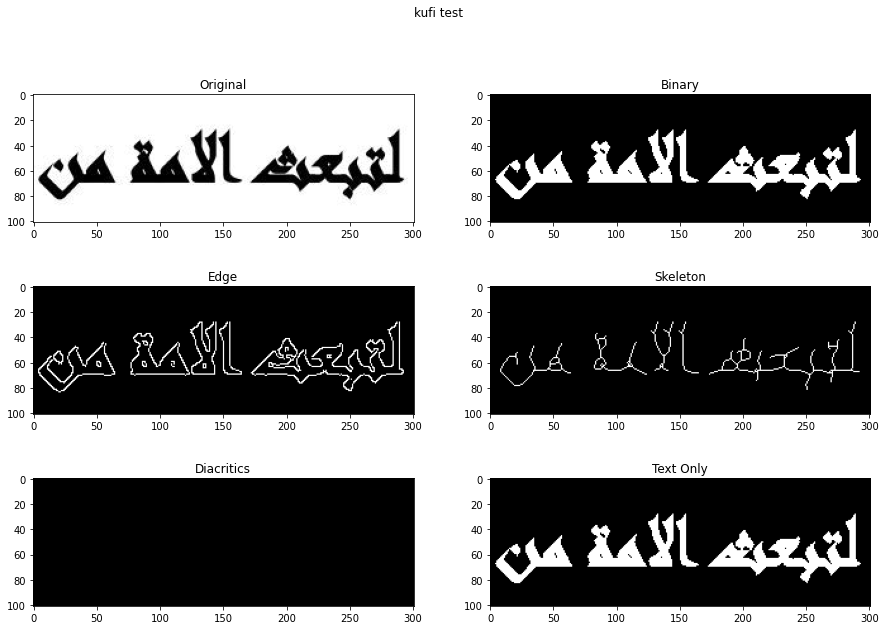

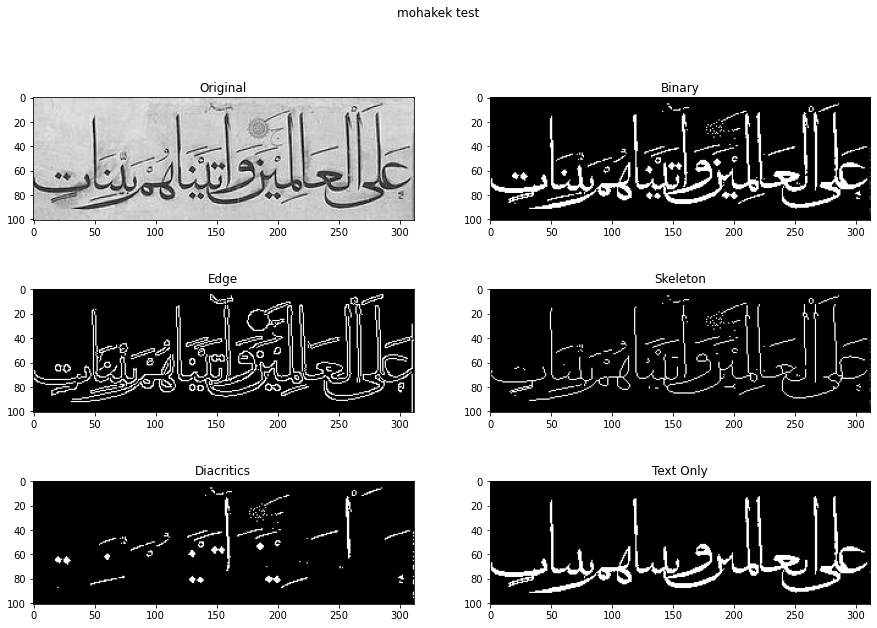

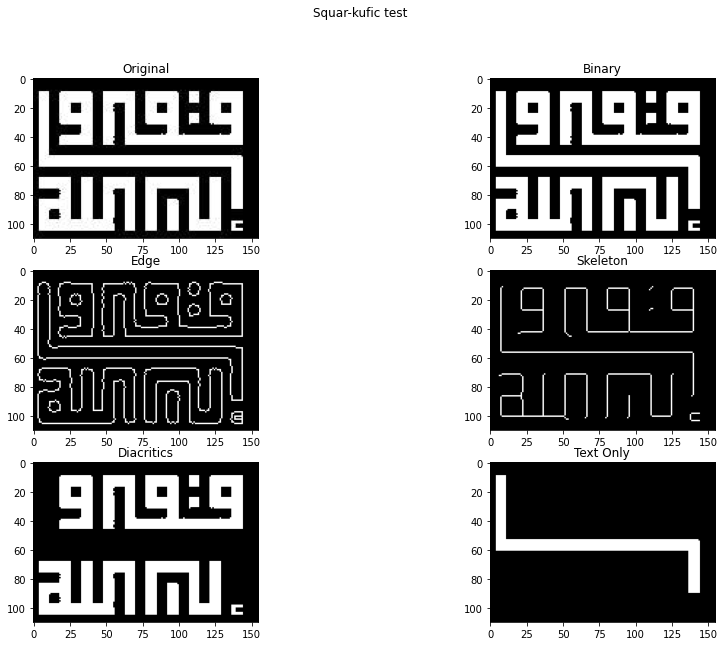

In [530]:
if __name__ == '__main__':
    testing()

In [531]:
def create_py():
    !jupyter nbconvert --to script preprocessing.ipynb

In [532]:
if __name__ == '__main__':
    create_py()

'jupyter' is not recognized as an internal or external command,
operable program or batch file.
